In this notebook I will apply the LSTM model into the data which was prepared in R.

### 1. Importing the libraries

In [113]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

In [2]:
fludat_pivot = pd.read_csv('./dataset/Flu_pivot.csv')

In [3]:
fludat_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sdate      546 non-null    object
 1   Processed  546 non-null    int64 
 2   A_total    546 non-null    int64 
 3   B_total    546 non-null    int64 
 4   All_total  546 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 21.5+ KB


In [4]:
fludat_pivot['sdate'] = pd.to_datetime(fludat_pivot['sdate'])

In [5]:
fludat_pivot.head()

,sdate,Processed,A_total,B_total,All_total
0,2010-01-04,9312,1999,1,2000
1,2010-01-11,10728,1404,15,1419
2,2010-01-18,9027,1135,49,1184
3,2010-01-25,8030,515,18,533
4,2010-02-01,7788,502,14,516


In [6]:
forecast_data = fludat_pivot.set_index(fludat_pivot['sdate'])['All_total']

In [7]:
forecast_data.name = 'Positive_cases'

In [75]:
forecast_data

sdate
2010-01-04    2000
2010-01-11    1419
2010-01-18    1184
2010-01-25     533
2010-02-01     516
              ... 
2020-05-18       3
2020-05-25       3
2020-06-01       1
2020-06-08       4
2020-06-15       0
Name: Positive_cases, Length: 546, dtype: int64

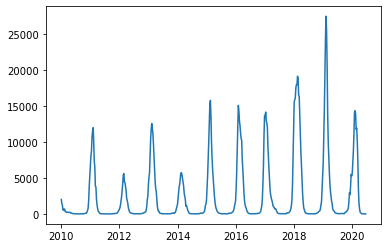

In [76]:
plt.plot(forecast_data)

In [82]:
np.array(forecast_data[:2])

array([2000, 1419], dtype=int64)

In [84]:
# Splitting the dataset into train and test 80% - 20%

train_size = int(len(forecast_data)*0.8)
test_size = len(forecast_data)-train_size

training_data = np.array(forecast_data[0:train_size])
test_data = np.array(forecast_data[train_size:len(forecast_data)])

In [86]:
 # LSTM are sensitive to the scale of the data, so we apply minmax scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scaled array
training_data_scaled = scaler.fit_transform(training_data.reshape(-1,1))
test_data_scaled = scaler.transform(test_data.reshape(-1,1))

In [91]:
training_data_scaled.shape

(436, 1)

In [92]:
test_data_scaled.shape

(110, 1)

In [99]:
training_data_scaled[0:3,0].tolist()

[0.10455806164634465, 0.07415354021665184, 0.061855670103092786]

In [100]:
# Within the 'training_data' and 'test_data', we create x_train,x_test, y_train, y_test

def create_data(dataset, time_step = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        data_X.append(a.tolist())
        data_Y.append(dataset[i + time_step, 0].tolist())
    return np.array(data_X), np.array(data_Y)

In [101]:
# time_step hyperparameter tuning
time_step = 3

X_train, y_train = create_data(training_data_scaled, time_step)
X_test, y_test = create_data(test_data_scaled, time_step)

In [102]:
print('X_train shape: ',X_train.shape, ', y_train shape: ',y_train.shape)
print('------------------------')
print('X_test shape: ',X_test.shape, ', y_test shape: ',y_test.shape)

X_train shape:  (432, 3) , y_train shape:  (432,)
------------------------
X_test shape:  (106, 3) , y_test shape:  (106,)


### LSTM model

In [104]:
# for LSTM we need to add an additional dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [57]:
# Create stack LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (3,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [114]:
model = Sequential()
model.add(Bidirectional(LSTM(units=64, input_shape=(3,1))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [115]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [118]:
EPOCHS = 40
H = model.fit(X_train,y_train, epochs = EPOCHS, batch_size = 1, validation_split=0.25, shuffle=False, verbose = 1)

Epoch 1/40
324/324 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0105
Epoch 2/40
324/324 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 3/40
324/324 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/40
324/324 [==============================] - 1s 2ms/step - loss: 9.1556e-04 - val_loss: 0.0025
Epoch 5/40
324/324 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/40
324/324 [==============================] - 1s 2ms/step - loss: 9.2994e-04 - val_loss: 0.0031
Epoch 7/40
324/324 [==============================] - 1s 2ms/step - loss: 7.6136e-04 - val_loss: 0.0022
Epoch 8/40
324/324 [==============================] - 1s 2ms/step - loss: 9.0793e-04 - val_loss: 0.0018
Epoch 9/40
324/324 [==============================] - 1s 2ms/step - loss: 8.7944e-04 - val_loss: 0.0028
Epoch 10/40
324/324 [==============================] - 1s 3ms/step - loss: 9.336

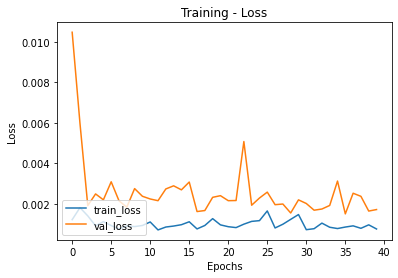

In [119]:
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model_training_plot.png")

In [121]:
# Prediction
y_pred = model.predict(X_test)

In [122]:
y_pred_realval = scaler.inverse_transform(y_pred)

In [129]:
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Scaled RMSE: ',lstm_rmse)
print('Inverse scaled RMSE: ', scaler.inverse_transform(np.array(lstm_rmse).reshape(1,-1))[0][0])

Scaled RMSE:  0.05547289815985165
Inverse scaled RMSE:  1062.0316109366051


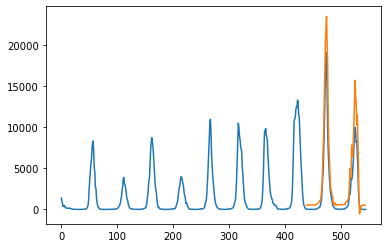

In [124]:
# plotting
look_back = 3
test_predict = np.empty_like(forecast_data_scaled)
test_predict[:,:] = np.nan
test_predict[len(X_train) + (look_back*2)+1 : len(forecast_data_scaled)-1, :] = y_pred_realval
plt.plot(scaler.inverse_transform(forecast_data_scaled))
plt.plot(test_predict)
plt.show()

This is a good model, not over and underfitted.

### Predicting for 2 years (104 weeks)

In [130]:
len(test_data)

110

In [261]:
x_input = test_data_scaled[len(test_data_scaled)-3:].reshape(1,-1)
prediction_arr = x_input.reshape(3,1)
temp_arr = np.vstack((x_input[:,1:].reshape(2,1),asd))
print(x_input)
print('---')
print(prediction_arr)
print('---')
print(temp_arr)

[[-5.23313622e-05  1.04662724e-04 -1.04662724e-04]]
---
[[-5.23313622e-05]
 [ 1.04662724e-04]
 [-1.04662724e-04]]
---
[[ 0.00010466]
 [-0.00010466]
 [ 0.02790079]]


In [262]:
prediction_arr = np.stack((prediction_arr,temp_arr))
print(prediction_arr)

[[[-5.23313622e-05]
  [ 1.04662724e-04]
  [-1.04662724e-04]]

 [[ 1.04662724e-04]
  [-1.04662724e-04]
  [ 2.79007852e-02]]]


In [275]:
temp_arr

array([[ 0.00010466],
       [-0.00010466],
       [ 0.02790079]])

In [280]:
np.append(prediction_arr,temp_arr.reshape(1,3,1), axis=0)

array([[[-5.23313622e-05],
        [ 1.04662724e-04],
        [-1.04662724e-04]],

       [[ 1.04662724e-04],
        [-1.04662724e-04],
        [ 2.79007852e-02]],

       [[ 1.04662724e-04],
        [-1.04662724e-04],
        [ 2.79007852e-02]]])

In [286]:
# We need the last 5 value from the test data to start the prediction
x_input = test_data_scaled[len(test_data_scaled)-3:].reshape(1,-1)

# x_input to list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# prediction_array
prediction_arr = x_input.reshape(3,1)

# find next 104 value
output = []
time_step = 3
i = 0

while(i<52):
    if(len(temp_input)>3):
        # last 5 element after the first loop
        x_input = np.array(temp_input[1:])
        #reshaping
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape(1, time_step, 1)
        # predict
        y_hat = model.predict(x_input, verbose = 0)
        
        # add to final pred arr
        temp_arr = np.vstack((x_input[:,1:].reshape(2,1),y_hat))
        prediction_arr = np.append(prediction_arr,temp_arr.reshape(1,3,1), axis=0)
        
        # adding to the temp list
        temp_input.append(y_hat[0][0].tolist())
        # change temp list to the last 5 value
        temp_input = temp_input[1:]
        # add prediction to output
        output.append(y_hat[0][0].tolist())
        i = i+1
    
    else:
        # last 5 value reshape and predict
        x_input = x_input.reshape(1, time_step, 1)
        y_hat = model.predict(x_input, verbose = 0)
        
        # add to final prediction arr
        temp_arr = np.vstack((x_input[:,1:].reshape(2,1),y_hat))
        prediction_arr = np.stack((prediction_arr,temp_arr))
        
        # adding the value to temp input list
        temp_input.append(y_hat[0][0].tolist())
        # adding the value to output list
        output.append(y_hat[0][0].tolist())
        i = i+1

prediction_arr = prediction_arr.reshape(prediction_arr.shape[0],prediction_arr.shape[1],1)
print(output)
print('---------------------------------')
print(prediction_arr)

[0.027900785207748413, 0.07653191685676575, 0.1605224460363388, 0.28428930044174194, 0.4513952136039734, 0.642491340637207, 0.8066637516021729, 0.8811414241790771, 0.8516197204589844, 0.7687242031097412, 0.6840196847915649, 0.6132614016532898, 0.5569127202033997, 0.5144193172454834, 0.48529312014579773, 0.46891558170318604, 0.464417427778244, 0.4704916179180145, 0.4851933419704437, 0.5058092474937439, 0.5289332866668701, 0.5508654713630676, 0.5683110356330872, 0.5791311264038086, 0.582770824432373, 0.5801410675048828, 0.573068380355835, 0.5636483430862427, 0.5537712574005127, 0.544890284538269, 0.5379645824432373, 0.5334901809692383, 0.5315632820129395, 0.5319534540176392, 0.5341842770576477, 0.5376229882240295, 0.5415788888931274, 0.5454028844833374, 0.5485745668411255, 0.5507605075836182, 0.5518345832824707, 0.5518596172332764, 0.5510402917861938, 0.5496621131896973, 0.5480314493179321, 0.5464268922805786, 0.545066237449646, 0.544089674949646, 0.5435570478439331, 0.5434557795524597, 

In [290]:
y_pred_2yrs = model.predict(prediction_arr)
y_pred_2yrs = scaler.inverse_transform(y_pred_2yrs.reshape(1,-1))

In [144]:
len(forecast_data)

546

In [298]:
y_pred_2yrs[0].shape

(53,)

In [301]:
y_pred_2yrs

array([[  535.1567,  1464.4484,  3069.4236,  5434.4844,  8627.711 ,
        12279.367 , 15416.538 , 16839.732 , 16275.602 , 14691.551 ,
        13072.935 , 11720.8125, 10644.046 ,  9832.038 ,  9275.466 ,
         8962.509 ,  8876.553 ,  8992.624 ,  9273.56  ,  9667.508 ,
        10109.387 , 10528.488 , 10861.856 , 11068.617 , 11138.168 ,
        11087.916 , 10952.766 , 10772.756 , 10584.015 , 10414.309 ,
        10281.965 , 10196.464 , 10159.642 , 10167.099 , 10209.727 ,
        10275.437 , 10351.028 , 10424.104 , 10484.712 , 10526.482 ,
        10547.007 , 10547.486 , 10531.829 , 10505.493 , 10474.333 ,
        10443.672 , 10417.671 , 10399.01  , 10388.832 , 10386.8955,
        10391.882 , 10401.766 , 10414.232 ]], dtype=float32)

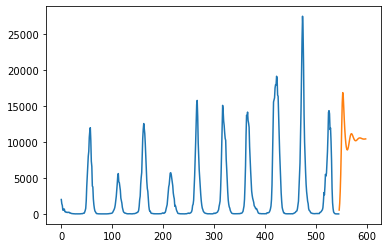

In [300]:
plt.plot(np.arange(0,546),forecast_data)
plt.plot(np.arange(546,546+53),y_pred_2yrs[0])